In [2]:
# Importar librerias standard de Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import *
from qiskit.visualization import *
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import *

import numpy as np

service = QiskitRuntimeService(channel="local")

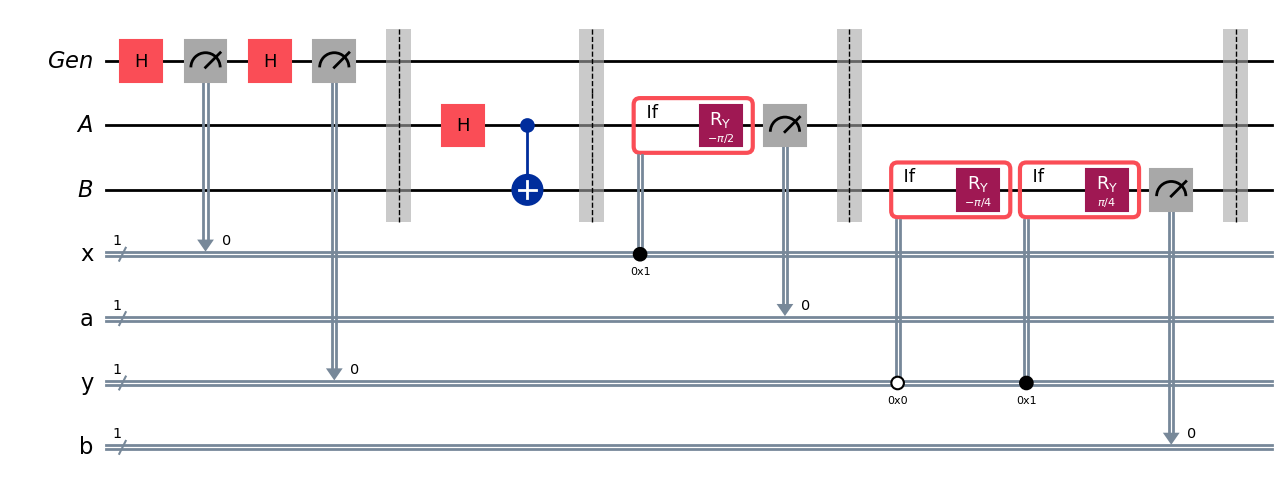

In [55]:
x_y_generator = QuantumRegister(1, "Gen")
A = QuantumRegister(1, "A")
B = QuantumRegister(1, "B")
x = ClassicalRegister(1, "x")
y = ClassicalRegister(1, "y")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

#Generar bits x e y aleatorios
protocol = QuantumCircuit(x_y_generator, A, B, x, a, y, b)
protocol.h(x_y_generator)
protocol.measure(x_y_generator, x)
protocol.h(x_y_generator)
protocol.measure(x_y_generator, y)
protocol.barrier()

#Generar qbits entrelazados para Alice y Bob
protocol.h(A)
protocol.cx(A, B)
protocol.barrier()

#Si Alice recive x=0, medir en {|0>, |1>}
#Si Alice recive x=1, medir en {|+>, |1>}
with protocol.if_test((x, 1)):
    protocol.ry(-2*(np.pi/4), A)
protocol.measure(A, a)
protocol.barrier()

#Si Bob recive x=0, medir en {|0>, |1>}
#Si Bomb recive x=1, medir en {|+>, |1>}
with protocol.if_test((y, 0)):
    protocol.ry(-2*(np.pi/8), B)
with protocol.if_test((y, 1)):
    protocol.ry(2*(np.pi/8), B)
protocol.measure(B, b)
protocol.barrier()

protocol.draw(output='mpl')

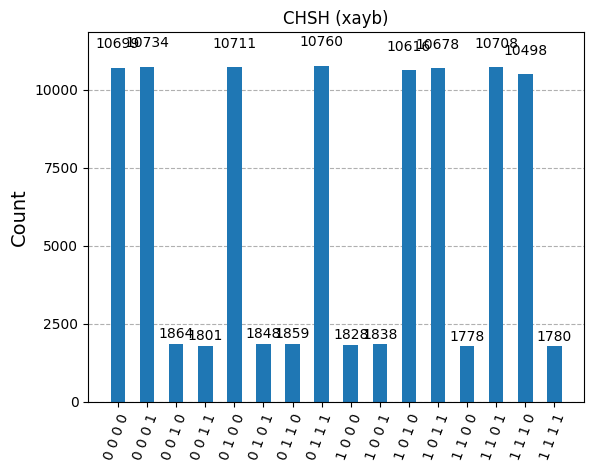

In [56]:
# Transpile for simulator
simulator = AerSimulator()
circuit = transpile(protocol, simulator)

# Run and get counts
SHOTS = 100000
result = simulator.run(circuit,shots=SHOTS).result()
counts = result.get_counts()
plot_histogram(counts, title='CHSH (xayb)')

In [57]:
winners = 0
for outcome, frecuency in counts.items():
    bits = outcome.replace(' ', '')[::-1]
    x_bit = int(bits[0])
    a_bit = int(bits[1])
    y_bit = int(bits[2])
    b_bit = int(bits[3])

    if (x_bit & y_bit == a_bit ^ b_bit): winners += frecuency

print(str((winners/SHOTS) *100) + "%")

85.404%
